<a href="https://colab.research.google.com/github/albim72/MACHINE_DEAP_LEARNING_06/blob/main/overfit_network_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-j713n2dt
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-j713n2dt
  Resolved https://github.com/tensorflow/docs to commit 16b9f2ae045d728d2133eb61439ff2d5c9817211
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=7557bcae781684ba75190683ef1578bc09ec88661f7cb9a304cc8a8b535236ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-r102ertb/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
import tensorflow as tf

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [ ]:
#ładowanie zbioru Higgsa
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 431s 0us/step


In [ ]:
FEATURES = 28

In [ ]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [ ]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features,label

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


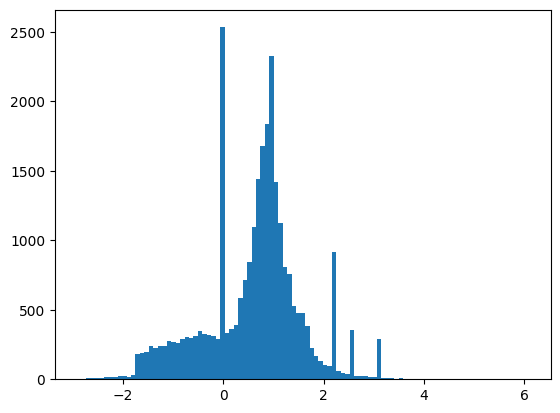

In [ ]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(),bins=101)

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [ ]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [ ]:
#opracowanie procedury szkolenia i komnstrukcji modelów
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

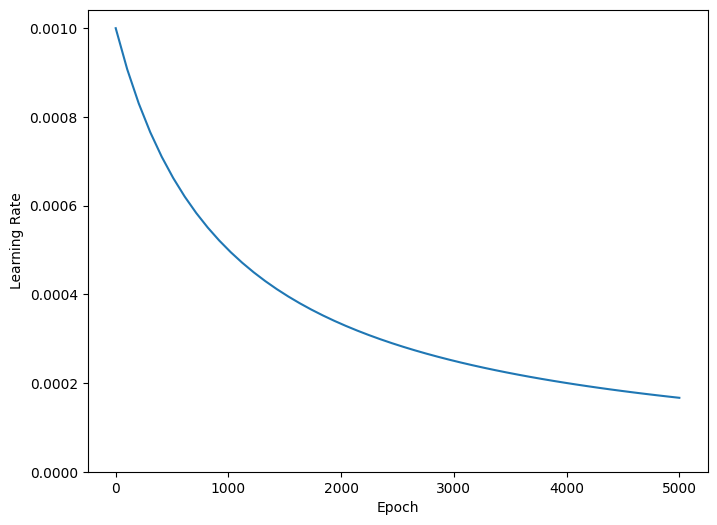

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [ ]:
def compile_and_fit(model,name,optimizer=None,max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'
                    ),'accuracy'
                ])
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose=0
  )
  return history

In [ ]:
from keras.layers.attention.multi_head_attention import activation
#pierwszy model - Tiny
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [ ]:
size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4822,  binary_crossentropy:0.7643,  loss:0.7643,  val_accuracy:0.4740,  val_binary_crossentropy:0.7064,  val_loss:0.7064,  
....................................................................................................
Epoch: 100, accuracy:0.5921,  binary_crossentropy:0.6299,  loss:0.6299,  val_accuracy:0.5810,  val_binary_crossentropy:0.6248,  val_loss:0.6248,  
............................................................

(0.5, 0.7)

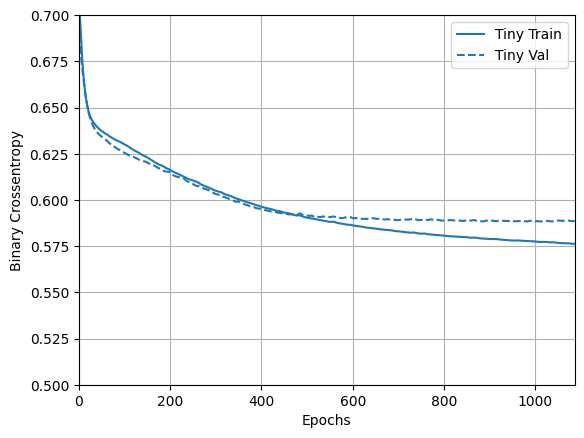

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [29]:
#mały model - small
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(1)
])

In [30]:
size_histories['Small'] = compile_and_fit(small_model,'size/Small')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                464       
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4909,  binary_crossentropy:0.8004,  loss:0.8004,  val_accuracy:0.4750,  val_binary_crossentropy:0.7496,  val_loss:0.7496,  
....................................................................................................
Epoch: 100, accuracy:0.6084,  binary_crossentropy:0.6218,  loss:0.6218,  

In [33]:
#średni model - medium
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64,activation='elu'),
    tf.keras.layers.Dense(64,activation='elu'),
    tf.keras.layers.Dense(1)
])

In [32]:
size_histories['Medium'] = compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                1856      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4913,  binary_crossentropy:0.6961,  loss:0.6961,  val_accuracy:0.4970,  val_binary_crossentropy:0.6764,  val_loss:0.6764,  
....................................

In [34]:
#duży model - large
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512,activation='elu'),
    tf.keras.layers.Dense(512,activation='elu'),
    tf.keras.layers.Dense(512,activation='elu'),
    tf.keras.layers.Dense(1)
])

In [36]:
size_histories['Large'] = compile_and_fit(large_model,'sizes/Large')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               14848     
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5099,  binary_crossentropy

Text(0.5, 0, 'Epochs [Log Scale]')

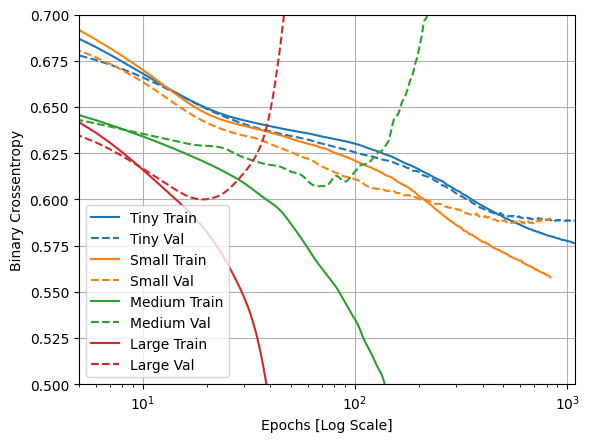

In [37]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epochs [Log Scale]")